## Chapter 5: Autoencoders

In this assignment, you will be working with the MNIST dataset (http://yann.lecun.com/exdb/mnist/). A cool application of autoencoders is in de-noising- let's see how they can be used to make noisy MNIST images clear.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Load the mnist dataset. We just need the train and test features (images) since we are de-noising. Cast the images to floats, and normalize them. Reshape them so that they are 3-dimensional with dimensions 28x28x1. Then, split the train set into training and validation sets, using a 0.3 ratio.

In [76]:
mnist = keras.datasets.mnist
#we don't need the labels!
(x_train, _), (x_test, _) = mnist.load_data()

#TODO: process the data. convert to float32, normalize, and
#reshape dimensions to dimensions of a black and white picture
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

#TODO: split x_train into training and validation sets using sklearn
train_x, val_x= train_test_split(x_train, test_size = 0.3, random_state=1024)

In [77]:
def create_noise(img, noise_factor):
    img_noisy = img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape) 
    img_noisy = np.clip(img_noisy, 0., 1.)
    return img_noisy

In [78]:
#TODO: make the test, train, and validation sets noisy by using the above helper function.
x_test_noisy = np.zeros_like(x_test)
for i in range(len(x_test)):
    x_test_noisy[i] = create_noise(x_test[i], 0.6)
    
x_train_noisy = np.zeros_like(train_x) 
for i in range(len(train_x)):
    x_train_noisy[i] = create_noise(train_x[i], 0.6)

x_val_noisy = np.zeros_like(val_x)   
for i in range(len(val_x)):
    x_val_noisy[i] = create_noise(val_x[i], 0.6)

Run the cell below. You can see that we've thoroughly obscured the mnist images to the point that they are barely recognizable.

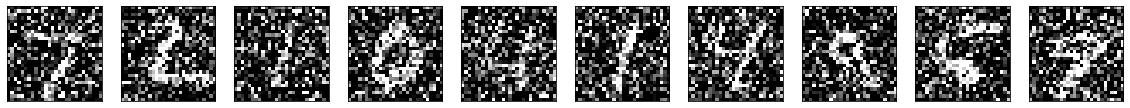

In [79]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We will be using the tf.keras functional API Model. Make an Input of the dimensions of the reshaped images, and use Conv2D and MaxPooling2D for the encoder, and Conv2D and UpSampling2D for the decoder.

In [107]:
#TODO: make a keras.layers.Input of the dimensions of an MNIST image
input_img = keras.Input(shape=(28, 28, 1))  
    
#TODO: use keras.layers.Conv2D and keras.layers.MaxPooling2D to construct your encoder
x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoder = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

#TODO: use keras.layers.Conv2D and keras.layers.UpSampling2D to construct your decoder
x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoder)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
decoder = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

#TODO: make your autoencoder using keras.models.Model, taking in your input and decoder
autoencoder = keras.models.Model(input_img, decoder)

#TODO: compile using adam optimizer and binary crossentropy loss
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Fit the autoencoder on the noisy training set, and the noisy validation set. Train for 30 epochs with a batch size of 128 with shuffle=True.

In [108]:
#TODO: fit your autoencoder!
autoencoder.fit(x_train_noisy, train_x,
                epochs=30,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val_noisy, val_x))

Train on 42000 samples, validate on 18000 samples
Epoch 1/30
42000/42000==============================] - 4s 97us/sample - loss: 0.1798 - val_loss: 0.1318
Epoch 2/30
42000/42000==============================] - 3s 82us/sample - loss: 0.1268 - val_loss: 0.1237
Epoch 3/30
42000/42000==============================] - 3s 82us/sample - loss: 0.1198 - val_loss: 0.1169
Epoch 4/30
42000/42000==============================] - 3s 82us/sample - loss: 0.1158 - val_loss: 0.1146
Epoch 5/30
42000/42000==============================] - 3s 82us/sample - loss: 0.1135 - val_loss: 0.1127
Epoch 6/30
42000/42000==============================] - 3s 82us/sample - loss: 0.1119 - val_loss: 0.1117
Epoch 7/30
42000/42000==============================] - 3s 82us/sample - loss: 0.1107 - val_loss: 0.1100
Epoch 8/30
42000/42000==============================] - 3s 82us/sample - loss: 0.1096 - val_loss: 0.1105
Epoch 9/30
42000/42000==============================] - 3s 82us/sample - loss: 0.1089 - val_loss: 0.1093
Epoch

Call predict on your autoencoder on the noisy test.

In [109]:
#TODO: call predict on your autoencoder
decoded_imgs = autoencoder.predict(x_test_noisy)

See your de-noised mnist images below. Good job!

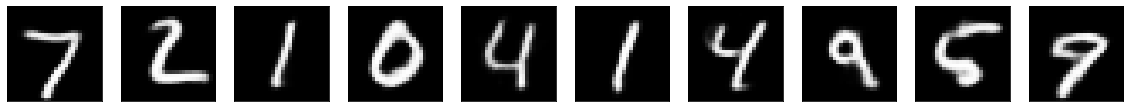

In [110]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Run the cells below to calculate the Structural Similarity Index (ssim) and evaluate your autoencoder!

In [111]:
im1 = tf.image.convert_image_dtype(decoded_imgs, tf.float32)
im2 = tf.image.convert_image_dtype(x_test, tf.float32)
ssim = tf.image.ssim(im1, im2, max_val=1.0)
float(tf.reduce_mean(ssim))

0.828329861164093

In [112]:
#run this to save your model
tf.keras.models.save_model(
    autoencoder,
    "./autoencoder.h5",
    overwrite=True,
    include_optimizer=True
)